#### This script trains a CNN model using transfer learning to classify human and horse images.

In [1]:
# Load packages/modules
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

In [2]:
# Download file with pre-trained weights 
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-09-01 21:19:23--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:400b:809::2010, 2607:f8b0:400b:80f::2010, 2607:f8b0:400b:800::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:400b:809::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  63.9MB/s    in 1.3s    

2020-09-01 21:19:24 (63.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
V3_weights_file = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

trained_V3_model = InceptionV3(input_shape=(150,150,3),
                               include_top = False,
                               weights = None)
trained_V3_model.load_weights(V3_weights_file)

# Set all weights in the pre-trained model to non-trainable
for layer in trained_V3_model.layers:
    layer.trainable = False

# Print the model summary
# trained_V3.summary()

#==========================================================================================
# Expected Output is too big too show here, it should have the following paramters.

#Total params: 21,802,784
#Trainable params: 0
#Non-trainable params: 21,802,784

In [4]:
last_layer = trained_V3_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [5]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [6]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024,activation='relu')(x)
# Add a dropout rate of 0.3
x = layers.Dropout(0.3)(x)                  
# Add a final sigmoid layer for binary classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(trained_V3_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

#model.summary()

#==========================================================================================
# Expected Output is too big too show here, it should have the following paramters.

# Total params: 47,512,481
# Trainable params: 38,537,217
# Non-trainable params: 8,975,264

In [7]:
# Get the Horse or Human Training dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate \
https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip 

--2020-09-01 21:19:28--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:400b:809::2010, 2607:f8b0:400b:80f::2010, 2607:f8b0:400b:800::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:400b:809::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  57.8MB/s    in 2.5s    

2020-09-01 21:19:31 (57.8 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-09-01 21:19:31--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:400b:809::2010, 2607:f8b0:400b:80f::2010, 2607:f8b0:400b:800::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:400b:809::2

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile

local_zip = "/tmp/horse-or-human.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = "/tmp/validation-horse-or-human.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

In [9]:
# Define the directories and files
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_horses_dir = os.path.join(train_dir,'horses')
train_humans_dir = os.path.join(train_dir,'humans')
validation_horses_dir = os.path.join(validation_dir,'horses')
validation_humans_dir = os.path.join(validation_dir,'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print('Number of training horse images:',len(train_horses_fnames))
print('Number of training human images:',len(train_humans_fnames))
print('Number of testing horse images:',len(validation_horses_fnames))
print('Number of testing human images:',len(validation_humans_fnames))

Number of training horse images: 500
Number of training human images: 527
Number of testing horse images: 128
Number of testing human images: 128


In [10]:
# Add ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True)

# Create ImageDataGenerator for validation data 
test_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150,150)
                                                   )     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode='binary',
                                                         target_size=(150,150)
                                                        )

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [11]:
# Train the model until it reaches 99.9% accuracy
callbacks = myCallback()
history = model.fit_generator(train_generator,
                              epochs=10,
                              steps_per_epoch = 1027//20,
                              verbose = 1,
                              callbacks =[callbacks],
                              validation_data = validation_generator
                             )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
51/51 [==============================] - 50s 972ms/step - loss: 0.1540 - accuracy: 0.9434 - val_loss: 0.0436 - val_accuracy: 0.9844
Epoch 2/10
51/51 [==============================] - 47s 915ms/step - loss: 0.0406 - accuracy: 0.9841 - val_loss: 3.1936e-04 - val_accuracy: 1.0000
Epoch 3/10
51/51 [==============================] - 63s 1s/step - loss: 0.0101 - accuracy: 0.9970 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 4/10
51/51 [==============================] - 47s 915ms/step - loss: 0.0214 - accuracy: 0.9921 - val_loss: 0.0041 - val_accuracy: 0.9961
Epoch 5/10
51/51 [==============================] - 48s 936ms/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.0434 - val_accuracy: 0.9844
Epoch 6/10
51/51 [==============================] - 46s 910ms/step - loss: 0.0140 - accuracy: 0.9950 - val_loss: 3.7988e-04 - val_accuracy: 1.0000
Epoch 7/10
51/51 [==============================] - 46s 912ms

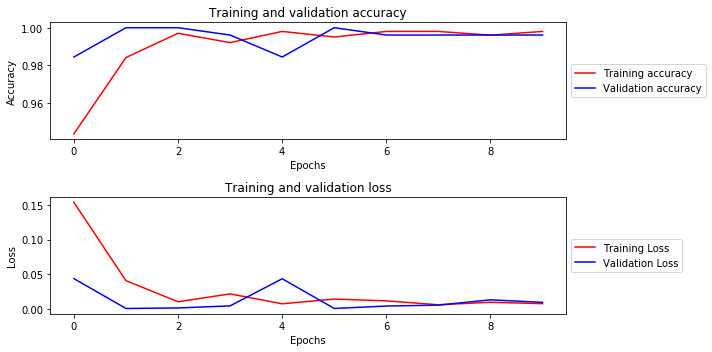

In [12]:
# Plot images
%matplotlib inline
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Get the metrices of performance (accuracy & loss)
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

#----------------------------------------------------------
# Plot training and validation accuracy per epoch
#----------------------------------------------------------
plt.subplots(2,1,figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.subplot(2,1,2)
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))

plt.tight_layout()